In [1]:
import csv
import time

In [2]:
def read(filename, date_idx, date_parse, year, bucket=7):
    days_in_year = 365
    
    freq = {}
    for period in range(0, int(days_in_year / bucket)):
        freq[period] = 0
        
    with open(filename, 'r') as csvfile:
        csvreader = csv.reader(csvfile)
        next(csvreader)
        for row in csvreader:
            if row[date_idx] == '':
                continue
            
            t = time.strptime(row[date_idx], date_parse)
            if t.tm_year == year and t.tm_yday < (days_in_year-1):
                freq[int(t.tm_yday / bucket)] += 1
    
    return freq


In [3]:
freq = read('311.csv', 1, '%m/%d/%Y %H:%M:%S %p', 2014)

In [4]:
freq

{0: 0,
 1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 0,
 15: 0,
 16: 0,
 17: 0,
 18: 0,
 19: 0,
 20: 0,
 21: 10889,
 22: 40240,
 23: 42125,
 24: 42673,
 25: 41721,
 26: 38446,
 27: 41915,
 28: 41008,
 29: 39011,
 30: 36069,
 31: 38821,
 32: 37050,
 33: 36967,
 34: 26834,
 35: 0,
 36: 0,
 37: 0,
 38: 0,
 39: 0,
 40: 0,
 41: 0,
 42: 0,
 43: 0,
 44: 0,
 45: 0,
 46: 0,
 47: 0,
 48: 0,
 49: 0,
 50: 0,
 51: 0}

Num samples 52


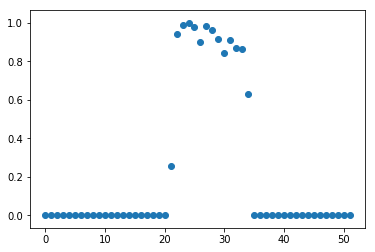

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

X_train = np.asarray(list(freq.keys()))
Y_train = np.asarray(list(freq.values()))
print("Num samples", str(len(X_train)))
maxY = np.max(Y_train)
nY_train = Y_train / np.max(Y_train)

plt.scatter(X_train, nY_train)
plt.show()

In [41]:
#learning_rate = 0.001
learning_rate = 1.5
training_epochs = 1000

X = tf.placeholder(tf.float32)
Y = tf.placeholder(tf.float32)

def model(X, mu, sig):
    return tf.exp(tf.div(tf.negative(tf.pow(tf.subtract(X, mu), 2.)), tf.multiply(2., tf.pow(sig, 2.))))

mu = tf.Variable(1., name="mu")
sig = tf.Variable(1., name="sig")
y_model = model(X, mu, sig)

In [42]:
cost = tf.square(Y-y_model)
train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

In [43]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

In [44]:
for epoch in range(training_epochs):
    for(x, y) in zip(X_train, nY_train):
        sess.run(train_op, feed_dict={X:x, Y:y})

In [45]:
mu_val = sess.run(mu)
sig_val = sess.run(sig)

In [46]:
print(mu_val)
print(sig_val)

27.232365
4.9030166


In [47]:
sess.close()

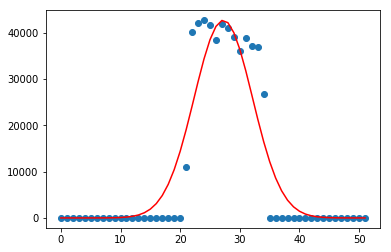

Prediction of week 35 21363.278811768592
Actual week 35 36967


In [48]:
plt.scatter(X_train, Y_train)
trY2 = maxY * (np.exp(-np.power(X_train - mu_val, 2.) / (2 * np.power(sig_val, 2.))))
plt.plot(X_train, trY2, 'r')
plt.show()
print("Prediction of week 35", trY2[33])
print("Actual week 35", Y_train[33])

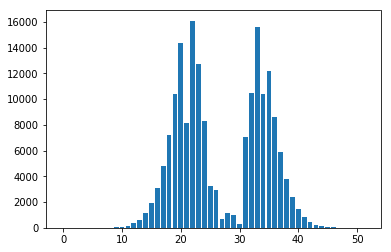

In [49]:
# plot the error
error = np.power(np.power(trY2 - Y_train, 2), 0.5)
#print(error)
plt.bar(X_train, error)
plt.show()

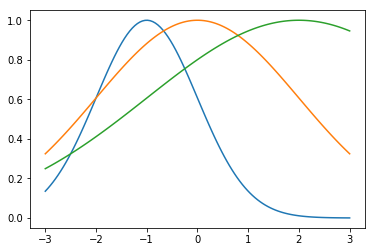

In [15]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
x_values = np.linspace(-3, 3, 120)
for mu, sig in [(-1, 1), (0, 2), (2, 3)]:
    plt.plot(x_values, gaussian(x_values, mu, sig))

plt.show()

# Try a polynomial model
We'll try a polynomial model now just to see.

In [16]:
learning_rate = 0.01
training_epochs = 40

#num_coeffs = 6
num_coeffs = 2
#trY_coeffs = [1, 2, 3, 4, 5, 6]
trY_coeffs = [1, 2]

X = tf.placeholder(tf.float32)
Y = tf.placeholder(tf.float32)

def model(X, w):
    terms = []
    for i in range(num_coeffs):
        term = tf.multiply(w[i], tf.pow(X, i))
        terms.append(term)
    return tf.add_n(terms)

In [17]:
w = tf.Variable([0.] * num_coeffs, name="parameters")
y_model = model(X, w)
cost = (tf.pow(Y-y_model, 2))

In [18]:
train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

In [19]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

In [20]:
for epoch in range(training_epochs):
    for(x, y) in zip(X_train, Y_train):
        sess.run(train_op, feed_dict={X:x, Y:y})

In [21]:
w_val = sess.run(w)
print(w_val)

[nan nan]


In [22]:
sess.close()

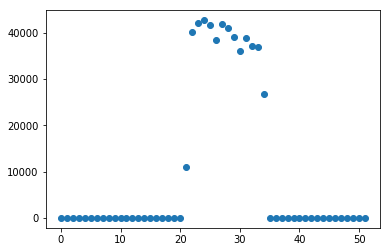

In [23]:
plt.scatter(X_train, Y_train)
trY2 = 0
for i in range(num_coeffs):
    trY2 += w_val[i] * np.power(X_train, i)
plt.plot(X_train, trY2, 'r')
plt.show()

# Use Regularization
We'll use regularlization and .7 / .3 train/test split to see if it helps.

In [24]:
def split_dataset(x_dataset, y_dataset, ratio):
    arr = np.arange(x_dataset.size)
    np.random.shuffle(arr)
    num_train = int(ratio * x_dataset.size)
    x_train = x_dataset[arr[0:num_train]]
    x_test = x_dataset[arr[num_train:x_dataset.size]]
    y_train = y_dataset[arr[0:num_train]]
    y_test = y_dataset[arr[num_train:x_dataset.size]]
    return x_train, x_test, y_train, y_test

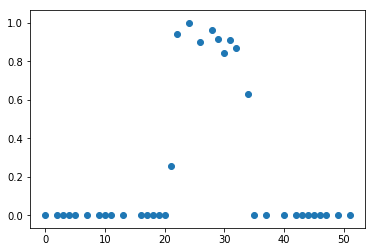

In [25]:
(x_train, x_test, y_train, y_test) = split_dataset(X_train, nY_train, 0.7)
plt.scatter(x_train, y_train)
plt.show()

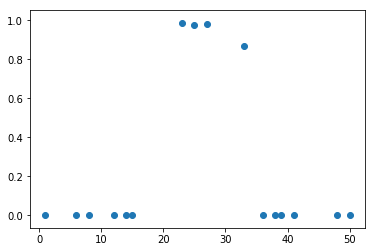

In [26]:
plt.scatter(x_test, y_test)
plt.show()

In [27]:
X = tf.placeholder(tf.float32)
Y = tf.placeholder(tf.float32)

In [28]:
def model(X, mu, sig):
    return tf.exp(tf.div(tf.negative(tf.pow(tf.subtract(X, mu), 2.)), tf.multiply(2., tf.pow(sig, 2.))))

mu = tf.Variable(1., name="mu")
sig = tf.Variable(1., name="sig")
y_model = model(X, mu, sig)

In [29]:
reg_lambda = 0.
cost = tf.div(tf.add(tf.reduce_sum(tf.square(Y-y_model)),
                     tf.multiply(reg_lambda, tf.reduce_sum(tf.square([mu, sig])))), 2*x_train.size)

In [30]:
learning_rate = 1.5
training_epochs = 5000
train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

Instructions for updating:
Use tf.cast instead.


In [31]:
mu_hist = tf.summary.scalar("mu", mu)
learning_rate = tf.summary.scalar("learning_rate", learning_rate)
sig_hist = tf.summary.scalar("sig", sig)
reg_lambda_hist = tf.summary.scalar("reg_lambda", reg_lambda)
cost_hist = tf.summary.scalar("cost_history", cost)
merged = tf.summary.merge_all()
writer = tf.summary.FileWriter("./logs")

In [32]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
writer.add_graph(sess.graph)

In [33]:
for reg_lambda in np.linspace(0, 1, 100):
    for epoch in range(training_epochs):
        summary_str,tOp = sess.run([merged,train_op], feed_dict = {X: x_train, Y: y_train})
        writer.add_summary(summary_str, epoch)
    final_cost = sess.run(cost, feed_dict = {X: x_test, Y: y_test})
    print('reg lambda', reg_lambda)
    print('final cost', final_cost)

reg lambda 0.0
final cost 0.06452212
reg lambda 0.010101010101010102
final cost 0.06452211
reg lambda 0.020202020202020204
final cost 0.06452211
reg lambda 0.030303030303030304
final cost 0.0645221
reg lambda 0.04040404040404041
final cost 0.064522095
reg lambda 0.05050505050505051
final cost 0.064522095
reg lambda 0.06060606060606061
final cost 0.064522095
reg lambda 0.07070707070707072
final cost 0.064522095
reg lambda 0.08080808080808081
final cost 0.064522095
reg lambda 0.09090909090909091
final cost 0.064522095
reg lambda 0.10101010101010102
final cost 0.06452209
reg lambda 0.11111111111111112
final cost 0.06452209
reg lambda 0.12121212121212122
final cost 0.06452209
reg lambda 0.13131313131313133
final cost 0.06452209
reg lambda 0.14141414141414144
final cost 0.06452208
reg lambda 0.15151515151515152
final cost 0.06452208
reg lambda 0.16161616161616163
final cost 0.06452208
reg lambda 0.17171717171717174
final cost 0.06452208
reg lambda 0.18181818181818182
final cost 0.06452208
r

In [34]:
mu_val = sess.run(mu)
sig_val = sess.run(sig)

In [35]:
print(mu_val)
print(sig_val)

0.9992233
0.22296421


In [36]:
sess.close()

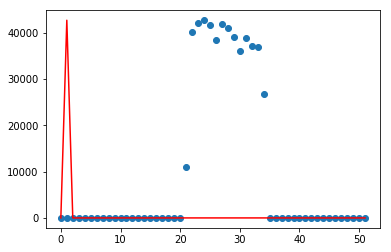

Prediction of week 35 0.0
Actual week 35 36967


In [38]:
plt.scatter(X_train, Y_train)
trY2 = maxY * (np.exp(-np.power(X_train - mu_val, 2.) / (2 * np.power(sig_val, 2.))))
plt.plot(X_train, trY2, 'r')
plt.show()
print("Prediction of week 35", trY2[33])
print("Actual week 35", Y_train[33])

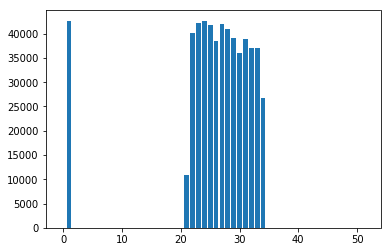

In [39]:
# plot the error
error = np.power(np.power(trY2 - Y_train, 2), 0.5)
#print(error)
plt.bar(X_train, error)
plt.show()